 Quelles sont les 20 premières stations en terme de validations ?
- Proposez une illustration graphique de ce classement.

- Proposez une classification des arrêts en vous basant sur le nombre de validations par catégorie de titre ?

- Quelles prédictions pouvez vous faire pour le nombre de validations dans les stations "OLYMPIADES" et "M. MONTROUGE" sur la plage du 24 au 30 juin ?


In [47]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from unidecode import unidecode
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [101]:
df = pd.read_csv('validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-sem.csv', encoding="latin-1", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835141 entries, 0 to 835140
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   JOUR             835141 non-null  object 
 1   CODE_STIF_TRNS   835141 non-null  int64  
 2   CODE_STIF_RES    835141 non-null  object 
 3   CODE_STIF_ARRET  835141 non-null  object 
 4   LIBELLE_ARRET    835141 non-null  object 
 5   ID_REFA_LDA      791293 non-null  float64
 6   CATEGORIE_TITRE  835141 non-null  object 
 7   NB_VALD          835141 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 51.0+ MB


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835141 entries, 0 to 835140
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   JOUR             835141 non-null  object 
 1   CODE_STIF_TRNS   835141 non-null  int64  
 2   CODE_STIF_RES    835141 non-null  object 
 3   CODE_STIF_ARRET  835141 non-null  object 
 4   LIBELLE_ARRET    835141 non-null  object 
 5   ID_REFA_LDA      791293 non-null  float64
 6   CATEGORIE_TITRE  835141 non-null  object 
 7   NB_VALD          835141 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 51.0+ MB


In [103]:
df.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2020-01-03,800,852,432,LE PERRAY,62804.0,TST,Moins de 5
1,2020-01-03,800,852,515,MAREIL-SUR-MAULDRE,64572.0,NAVIGO,18
2,2020-01-03,800,852,526,MAULE,64674.0,AMETHYSTE,Moins de 5
3,2020-01-03,800,852,538,MEUDON,70515.0,TST,Moins de 5
4,2020-01-03,800,852,561,MONTPARNASSE,71139.0,IMAGINE R,1600


In [105]:
df.query("JOUR == '2020-01-03' and LIBELLE_ARRET == 'MONTPARNASSE'")

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
4,2020-01-03,800,852,561,MONTPARNASSE,71139.0,IMAGINE R,1600
68782,2020-01-03,100,110,562,MONTPARNASSE,74040.0,?,39
69438,2020-01-03,800,852,561,MONTPARNASSE,71139.0,AMETHYSTE,142
69439,2020-01-03,800,852,561,MONTPARNASSE,71139.0,FGT,231
69440,2020-01-03,800,852,561,MONTPARNASSE,71139.0,NAVIGO,10457
69441,2020-01-03,800,852,561,MONTPARNASSE,71139.0,TST,370
383098,2020-01-03,100,110,562,MONTPARNASSE,74040.0,FGT,Moins de 5
383099,2020-01-03,100,110,562,MONTPARNASSE,74040.0,NAVIGO,5
762197,2020-01-03,800,852,561,MONTPARNASSE,71139.0,?,411
762200,2020-01-03,800,852,561,MONTPARNASSE,71139.0,NAVIGO JOUR,31


In [107]:
df['LIBELLE_ARRET'].nunique()

677

## Quelles sont les 20 premières stations en terme de validations ?

In [27]:
df[df['NB_VALD'].str.contains('[A-Za-z]')]['NB_VALD'].unique()

array(['Moins de 5'], dtype=object)

In [35]:
df['NB_VALD'].replace('Moins de 5', 5, inplace=True)
df['NB_VALD'] = df['NB_VALD'].astype('int')

In [51]:
df1 = df.groupby('LIBELLE_ARRET', as_index=False).agg(
    NB_VALD_TOTAL=('NB_VALD', 'sum')
).sort_values(
    by=['NB_VALD_TOTAL'], 
    ascending=False).head(20)
df1

,LIBELLE_ARRET,NB_VALD_TOTAL
563,SAINT-LAZARE,17775691
238,GARE DU NORD,7538767
415,MONTPARNASSE,6726449
236,GARE DE L'EST,5842835
291,LA DEFENSE-GRANDE ARCHE,5414079
237,GARE DE LYON,4077938
47,BIBLIOTHEQUE FRANCOIS MITTERRAND,3251331
330,LES HALLES,3034142
123,CHATELET-LES HALLES,2867116
37,BASTILLE,2433891


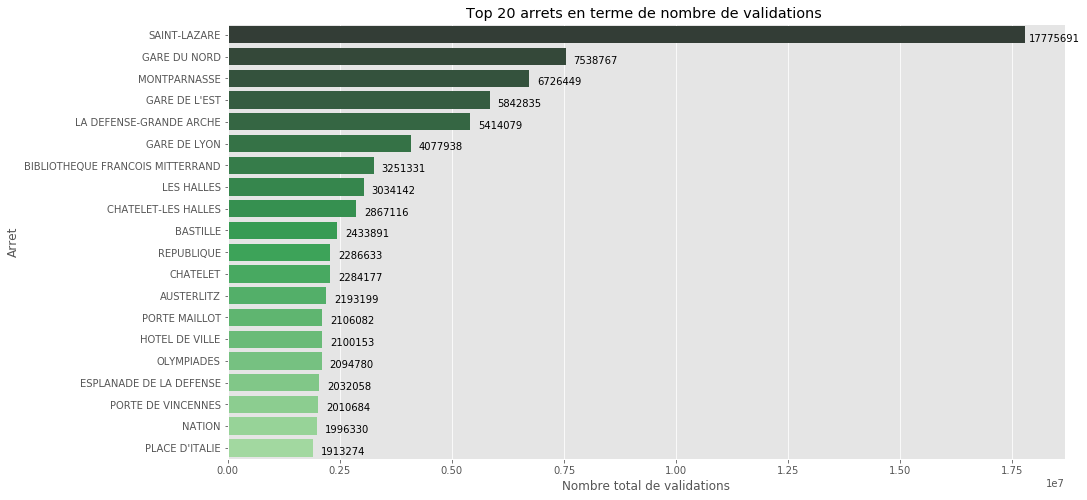

In [109]:
plt.figure(figsize=(15, 8))
pal = sns.color_palette("Greens_d", len(df1))
rank = df1["NB_VALD_TOTAL"].argsort().argsort()
g = sns.barplot(x='NB_VALD_TOTAL', y='LIBELLE_ARRET', data=df1,
            palette=np.array(pal[::-1])[rank],  
            capsize=0.05,             
            saturation=8,             
            errcolor='gray', 
            errwidth=2
            )
g.set(title='Top 20 arrets en terme de nombre de validations ', 
      xlabel='Nombre total de validations', 
      ylabel='Arret'
     )
for p in g.patches:
        g.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width(), p.get_y()+p.get_height()), 
                   ha='center', va='center', xytext=(30, 5), 
                   textcoords='offset points'
                  )